<h1><center> TIME SERIES FORECASTING </center></h1>

## 1) SETUP

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.preprocessing import OneHotEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ModuleNotFoundError: No module named 'seaborn'

## 2) Reading the files

In [2]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

# train_df : 
train_df = pd.read_csv(comp_dir / 'train.csv', parse_dates=['date'], infer_datetime_format=True)

#test_df = pd.read_csv(comp_dir / 'test.csv', index_col='date', parse_dates=['date'],)
#stores_df = pd.read_csv(comp_dir / 'stores.csv', index_col='date', parse_dates=['date'],)
#oil_df = pd.read_csv('comp_dir / 'oil.csv', index_col='date', parse_dates=['date'],)
holidays_df = pd.read_csv(
    comp_dir / 'holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

## 3) Set Matplotlib Defaults

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

## 4) Store sales Dataframe 

In [4]:
store_sales = train_df.copy()
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

store_sales

id     sales  \
date       store_nbr family                                          
2013-01-01 1         AUTOMOTIVE                        0     0.000   
                     BABY CARE                         1     0.000   
                     BEAUTY                            2     0.000   
                     BEVERAGES                         3     0.000   
                     BOOKS                             4     0.000   
...                                                  ...       ...   
2017-08-15 9         POULTRY                     3000883   438.133   
                     PREPARED FOODS              3000884   154.553   
                     PRODUCE                     3000885  2419.729   
                     SCHOOL AND OFFICE SUPPLIES  3000886   121.000   
                     SEAFOOD                     3000887    16.000   

                                                 onpromotion  
date       store_nbr family                                   
2013-01-01 1         AUTOMOTIVE                            0  
                     BABY CARE                             0  
                     BEAUTY                                0  
                     BEVERAGES                             0  
                     BOOKS                                 0  
...                                                      ...  
2017-08-15 9         POULTRY                               0  
                     PREPARED FOODS                        1  
                     PRODUCE                             148  
                     SCHOOL AND OFFICE SUPPLIES            8  
                     SEAFOOD                               0  

[3000888 rows x 3 columns]

## 5) Average sales Series

In [5]:
average_sales = store_sales.groupby('date').mean()['sales']

average_sales

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
                 ...    
2017-08-11    463.733851
2017-08-12    444.798280
2017-08-13    485.768618
2017-08-14    427.004717
2017-08-15    427.980884
Freq: D, Name: sales, Length: 1684, dtype: float64

---

## 6.1) Linear Regression Model with a time-step feature
on the series of average product sales. The target is in a column called 'sales'.

In [6]:
avg_sales_df = average_sales.to_frame()

# Create a time dummy
time = np.arange(len(avg_sales_df.index)) # array([ 0, 1, 2, ..., 1681, 1682, 1683])

avg_sales_df['time'] = time 

# Create training data
X = avg_sales_df.loc[:, ['time']]  # features (dataframe)
y = avg_sales_df.loc[:, 'sales'] # target (series)

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

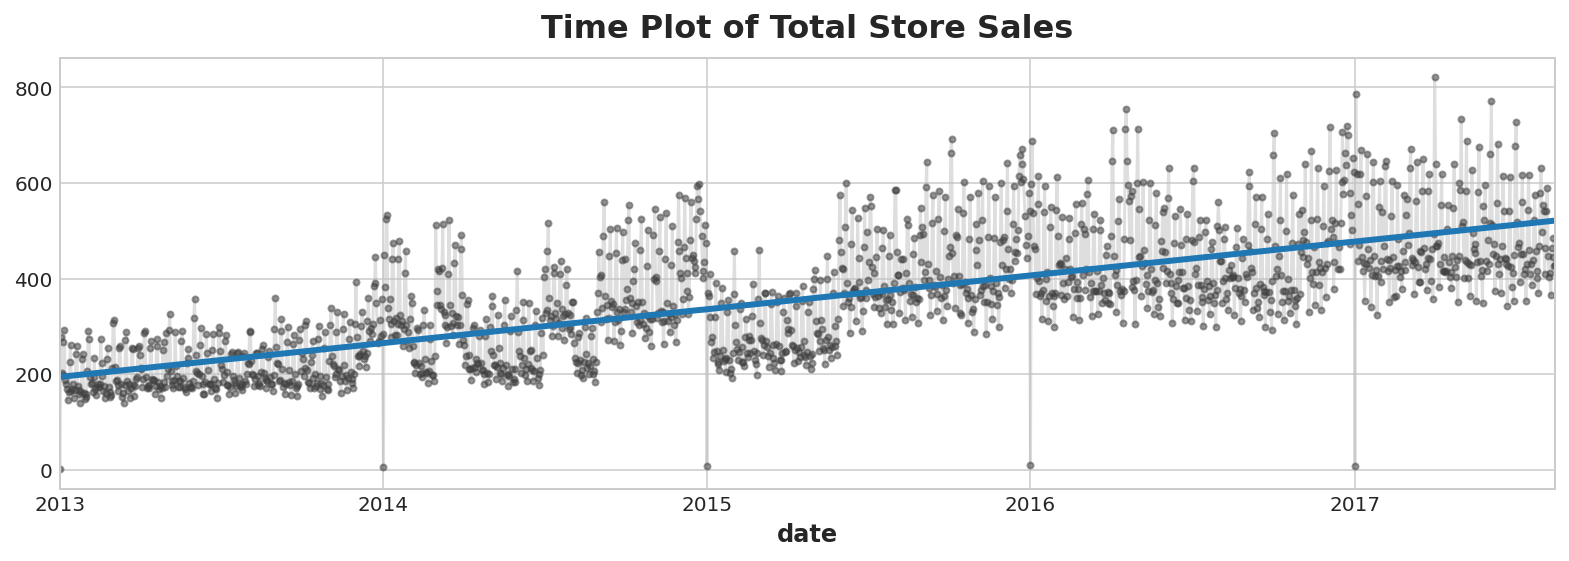

In [7]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

Time-step features let you model time dependence. A series is time dependent if its values can be predicted from the time they occured. In the previous Sales series, we can predict that sales later in the month are generally higher than sales earlier in the month

## 6.2) Linear regression Model with a lag feature 
on the series of average product sales. The target is in a column of df called 'sales'.

In [8]:
avg_sales_df = average_sales.to_frame()

# Create a lag feature from the target 'sales'
lag_1 = avg_sales_df['sales'].shift(1)

avg_sales_df['lag_1'] = lag_1  # add to dataframe

X = avg_sales_df.loc[:, ['lag_1']]
X.dropna(inplace=True)  # features

y = avg_sales_df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X, y)

# Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

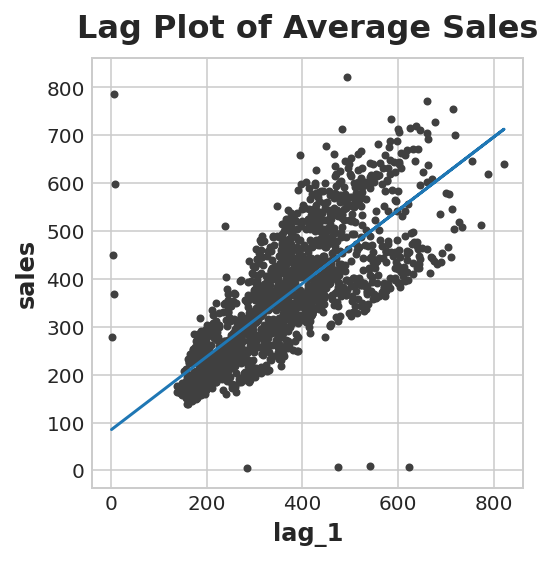

In [9]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

You can see from the lag plot that sales on one day (sales) are correlated with sales from the previous day (Lag_1). When you see a relationship like this, you know a lag feature will be useful.

More generally, lag features let you model serial dependence. A time series has serial dependence when an observation can be predicted from previous observations. In Sales, we can predict that high sales on one day usually mean high sales the next day.

Adapting machine learning algorithms to time series problems is largely about feature engineering with the time index and lags. We will use linear regression for its simplicity, but these features will be useful whichever algorithm you choose for your forecasting task.

What does this prediction from a lag feature mean about how well we can predict the series across time? The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past.

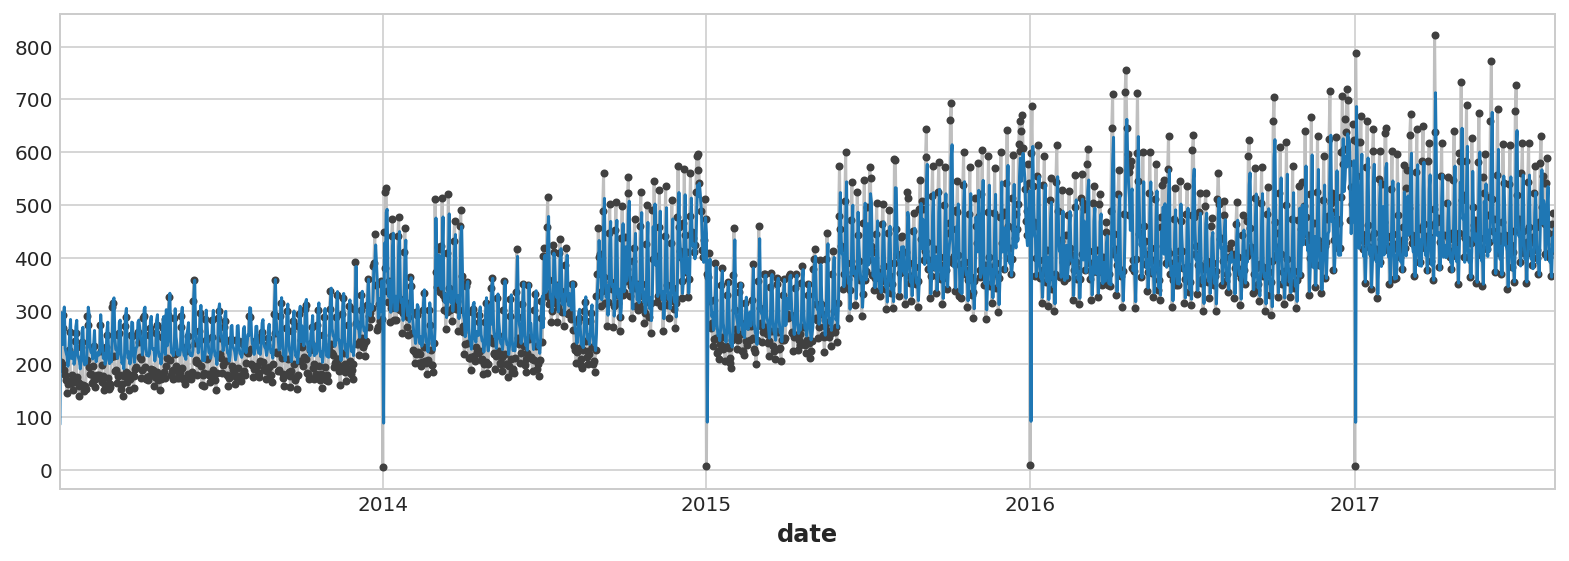

In [10]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

## 6.3) Conclusion:
The best time series models will usually include some combination of time-step features and lag features

---

## 7) Moving Average Plots
To see what kind of trend a time series might have, we can use a moving average plot. 
The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

Let's make a moving average plot to see what kind of trend this series has. Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year.

To create a moving average, first use the rolling method to begin a windowed computation. Follow this by the mean method to compute the average over the window.

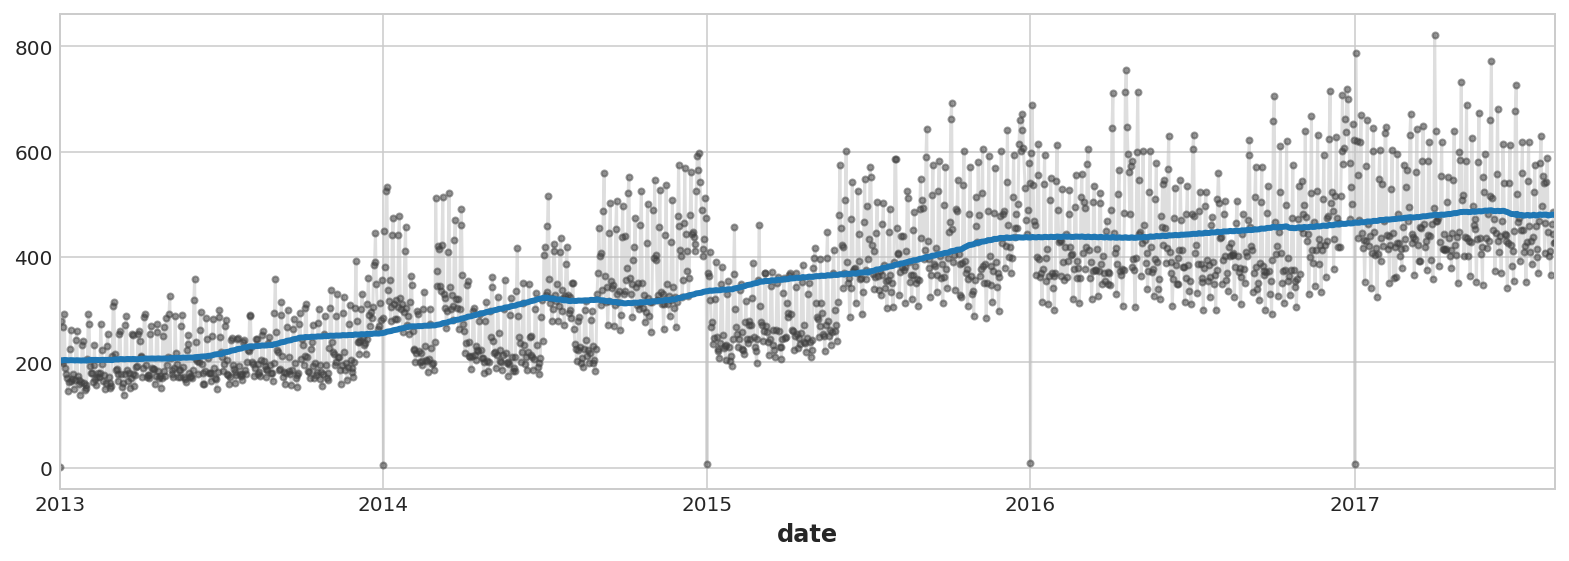

In [11]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

## 7.1) Identify Trend: 
As we can see, the trend of average sales appears to be about cubic.

## 8) Create a Trend Feature:
We'll use DeterministicProcess to create a feature set for a cubic trend model. Also create features for a 90-day forecast.

Previously, we engineered our time dummy in Pandas directly. From now on, however, we'll use a function from the statsmodels library called DeterministicProcess. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

In [12]:
# from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

dp = DeterministicProcess(
        index=average_sales.index,
        constant=False,
        order=3,
        drop=True
)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

X_fore.tail()

,trend,trend_squared,trend_cubed
2017-11-09,1770.0,3132900.0,5.545233e+09
2017-11-10,1771.0,3136441.0,5.554637e+09
2017-11-11,1772.0,3139984.0,5.564052e+09
2017-11-12,1773.0,3143529.0,5.573477e+09
2017-11-13,1774.0,3147076.0,5.582913e+09


To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [13]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

You can see the a plot of the result by running the next cell.

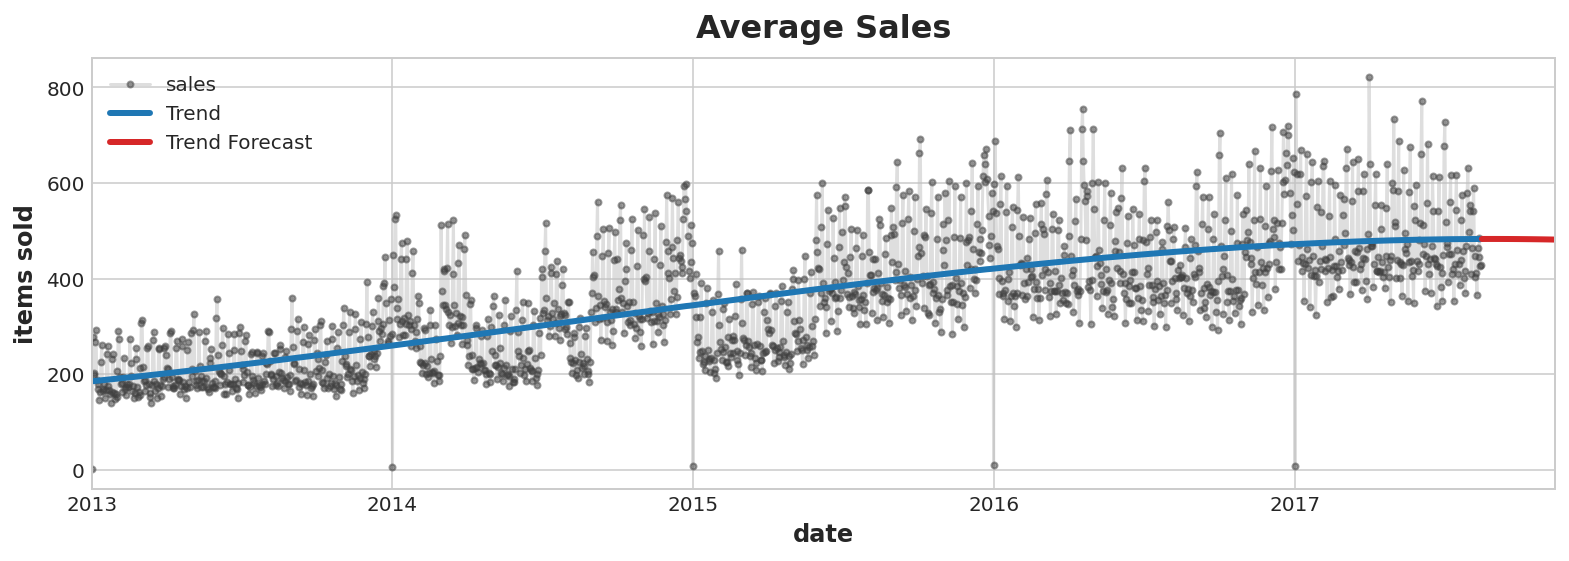

In [14]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a cubic trend was the right decision in this case.

The trend models we learned about in this lesson turn out to be useful for a number of reasons. Besides acting as a baseline or starting point for more sophisticated models, we can also use them as a component in a "hybrid model" with algorithms unable to learn trends (like XGBoost and random forests). We'll learn more about this technique in Lesson 5.

---

### 9) SEASONALITY

We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

We will learn two kinds of features that model seasonality. The first kind, **indicators**, is best for a season with few observations, like a weekly season of daily observations. The second kind, **Fourier** features, is best for a season with many observations, like an annual season of daily observations.

### 10) Holiday events Dataframe

In [15]:
holidays_events = holidays_df.copy()
holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


### 10.1) New Store Sales Dataframe and Average Sales Series

In [16]:
store_sales_nuevo = pd.read_csv(
        comp_dir / "train.csv",
        usecols=["store_nbr", "family", "date", "sales"],
        dtype={
            "store_nbr": "category",
            "familiy": "category",
            "sales": "float32",
        },
        parse_dates=['date'],
        infer_datetime_format=True,
)
store_sales_nuevo['date'] = store_sales_nuevo.date.dt.to_period('D')
store_sales_nuevo = store_sales_nuevo.set_index(['store_nbr', 'family', 'date']).sort_index()

average_sales_nuevo = (
    store_sales_nuevo.groupby('date').mean().squeeze().loc['2017']
)

### 11) Seasonal Plots and Periodgrams

### 11.1) Some Useful Functions:
        seasonal_plot() , plot_periodgram()

In [17]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodgram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe.

We will examine the following **seasonal plot** to try to discover seasonal patterns.

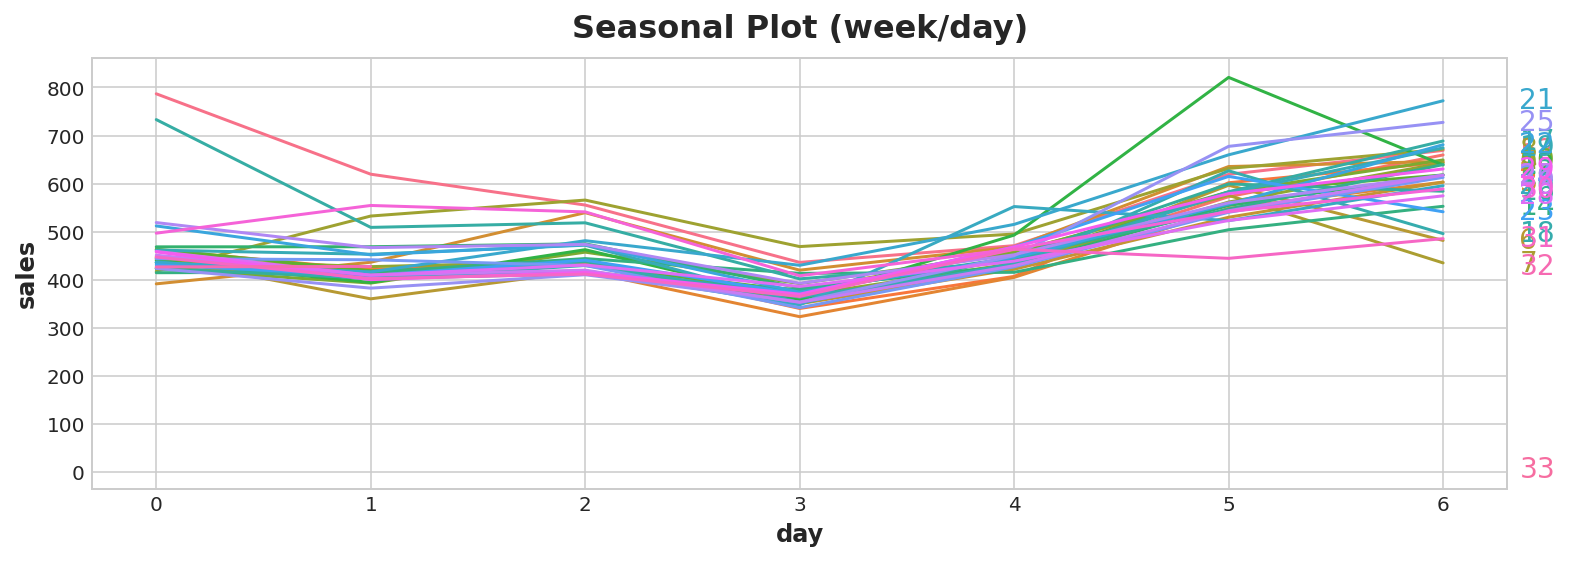

In [18]:
X = average_sales_nuevo.to_frame()
X["week"] = X.index.week # the seasonal period (period)
X["day"] = X.index.dayofweek # the x-axis (freq)
seasonal_plot(X, y='sales', period='week', freq='day');

There is a clear weekly seasonal pattern in this series, higher on weekend.

Let's also take a look at the following periodgram. The **periodogram** tells you the strength of the frequencies in a time series.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

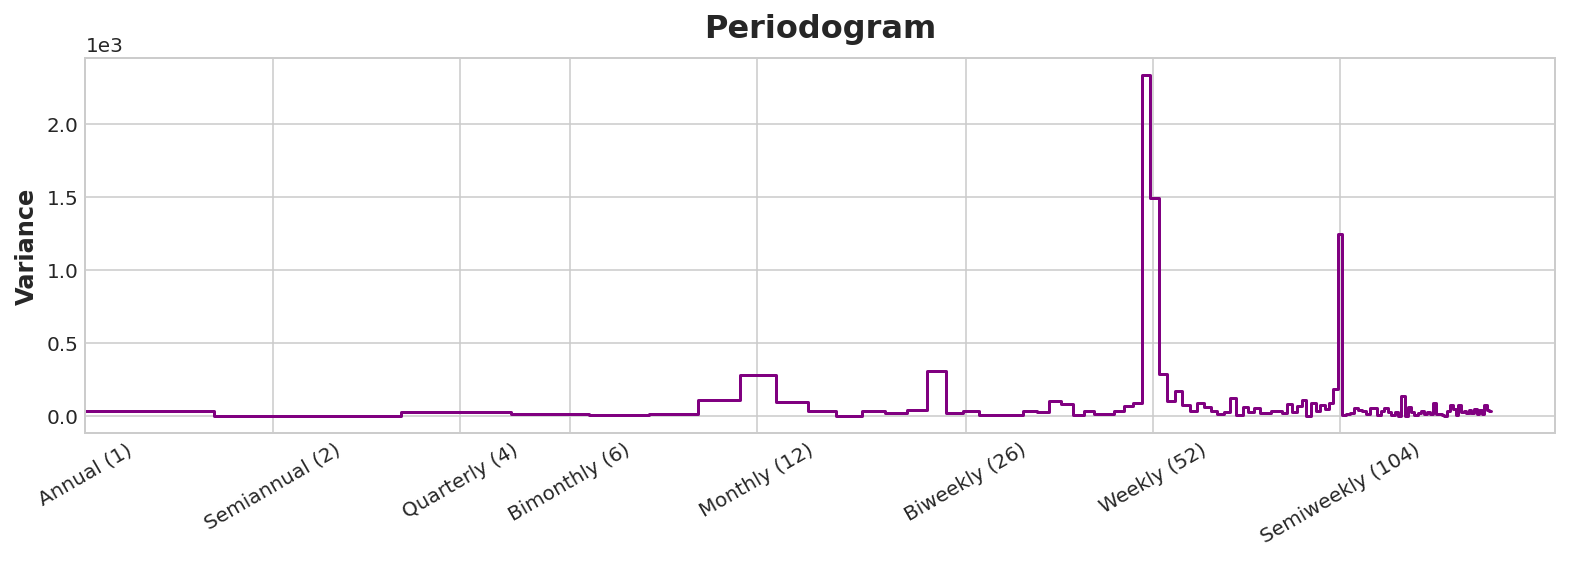

In [19]:
plot_periodgram(average_sales_nuevo)

From left to right, the periodogram drops off after Monthly, twelve times a year. That was why we'll choose 12 Fourier pairs to model the annual season. The Weekly frequency we ignore since it's better modeled with indicators.

Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

### 12) Create Seasonal Features

We'll create our seasonal features using DeterministicProcess, the same utility we used to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [20]:
y = average_sales_nuevo.copy()

fourier = CalendarFourier(freq='M', order=4) #  4 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=y.index,
    constant=True,       # dummy feature for bias (y-intercept)
    order=1,             # trend (order 1 means linear)
    # YOUR CODE HERE
    seasonal=True,       # weekly seasonality (indicators)
    additional_terms=[fourier], # annual seasonality (fourier)
    drop=True,           # drop terms to avoid collinearity
)
X = dp.in_sample()

Now run this cell to fit the seasonal model.

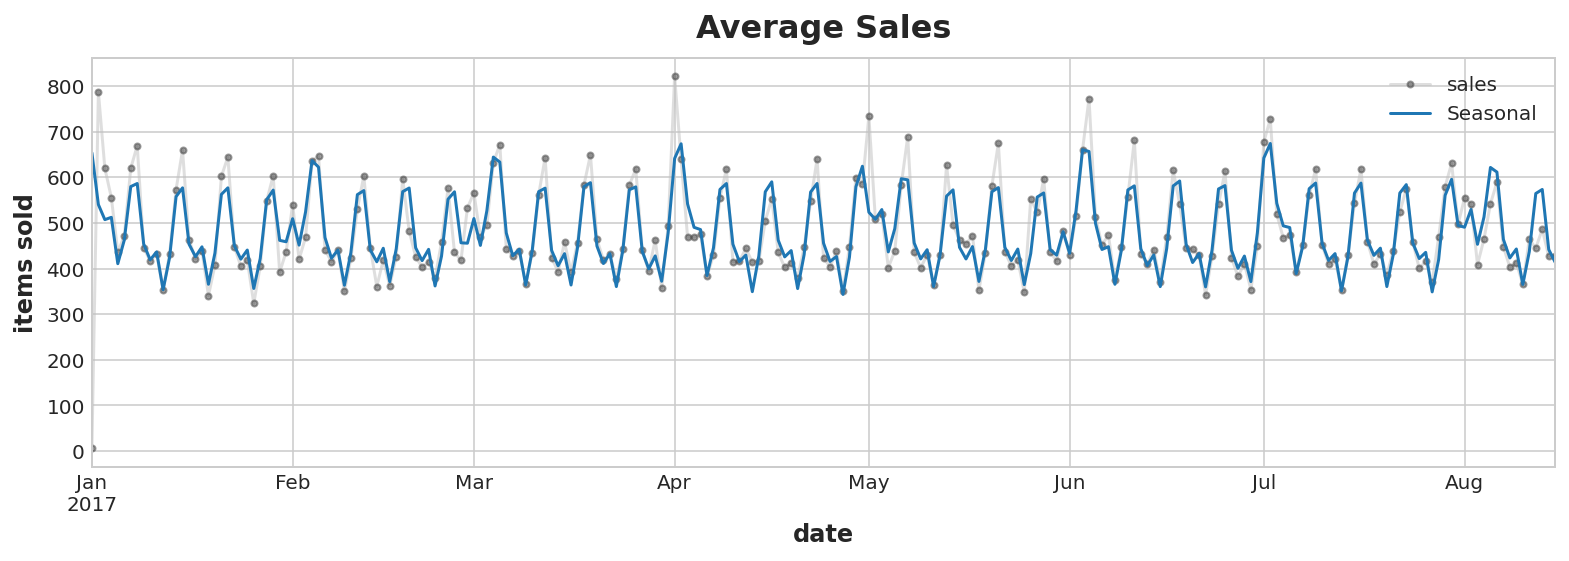

In [21]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

 We'll add a 90-day forecast to see how our model extrapolates beyond the training data.

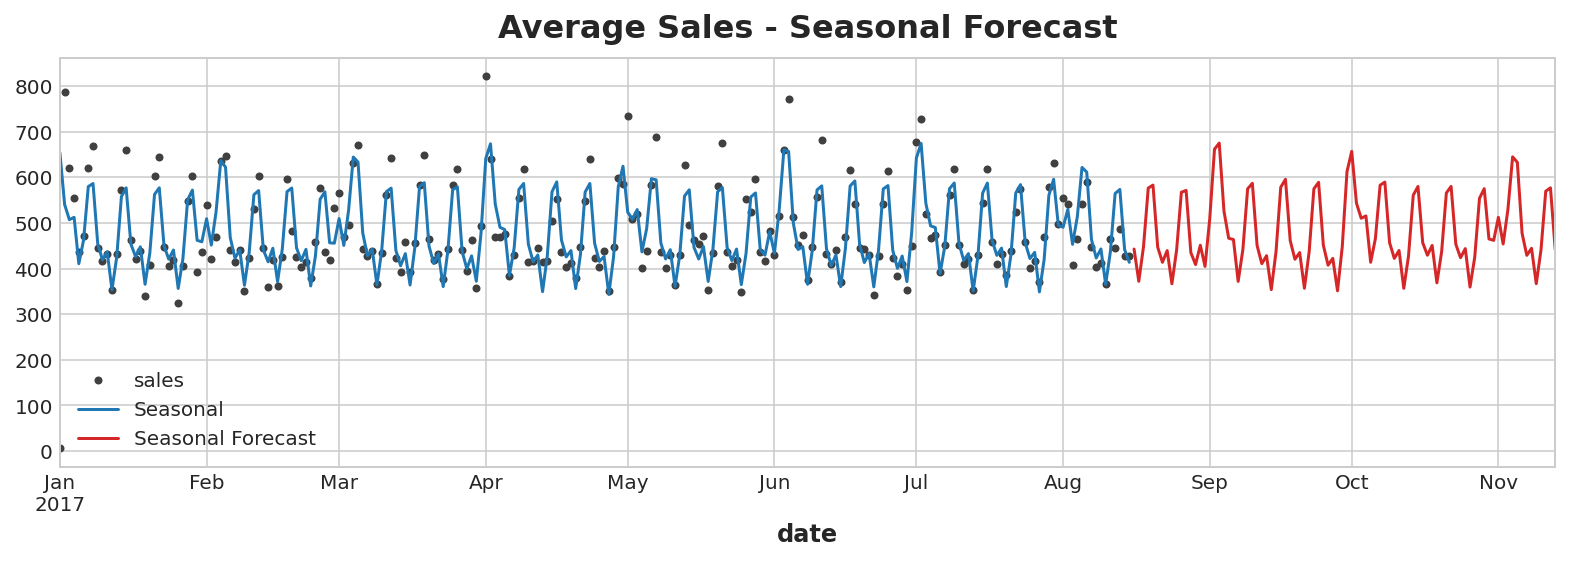

In [22]:
# mio

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Average Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

There's still more we can do with time series to improve our forecasts. In the next lesson, we'll learn how to use time series themselves as a features. Using time series as inputs to a forecast lets us model the another component often found in series: cycles.

### 13) Detrending or Deseasonalizing

Removing from a series its trend or seasons is called detrending or deseasonalizing the series.

Look at the periodogram of the deseasonalized series.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  


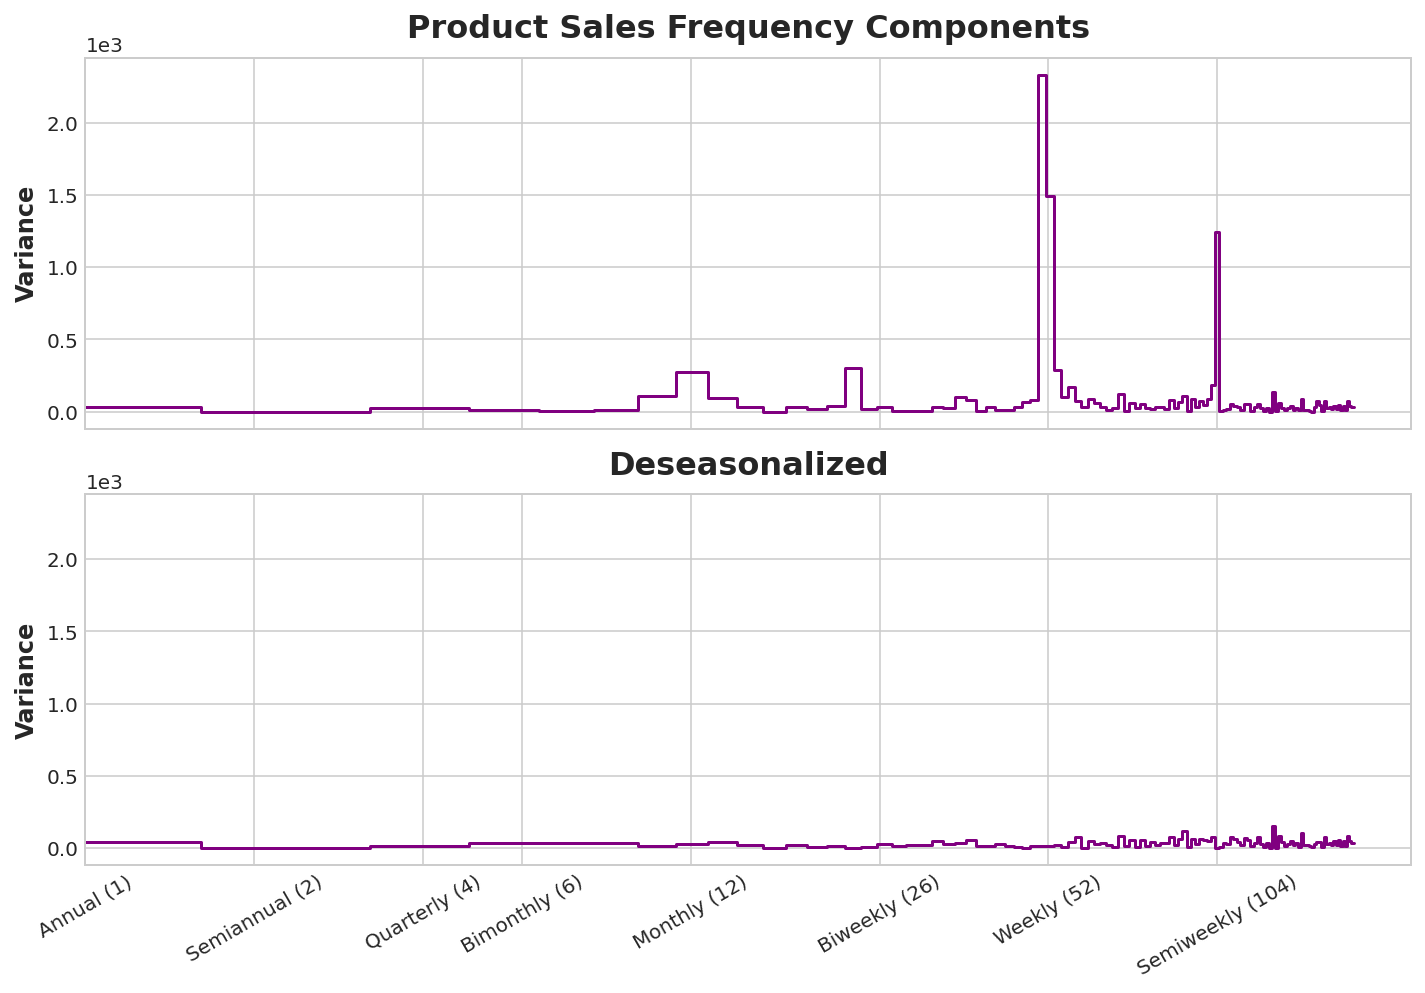

In [23]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodgram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodgram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

### Holidays Dataframe

The Store Sales dataset includes a table of Ecuadorian holidays.

In [24]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


From a plot of the deseasonalized Average Sales, it appears **these holidays could have some predictive power.**

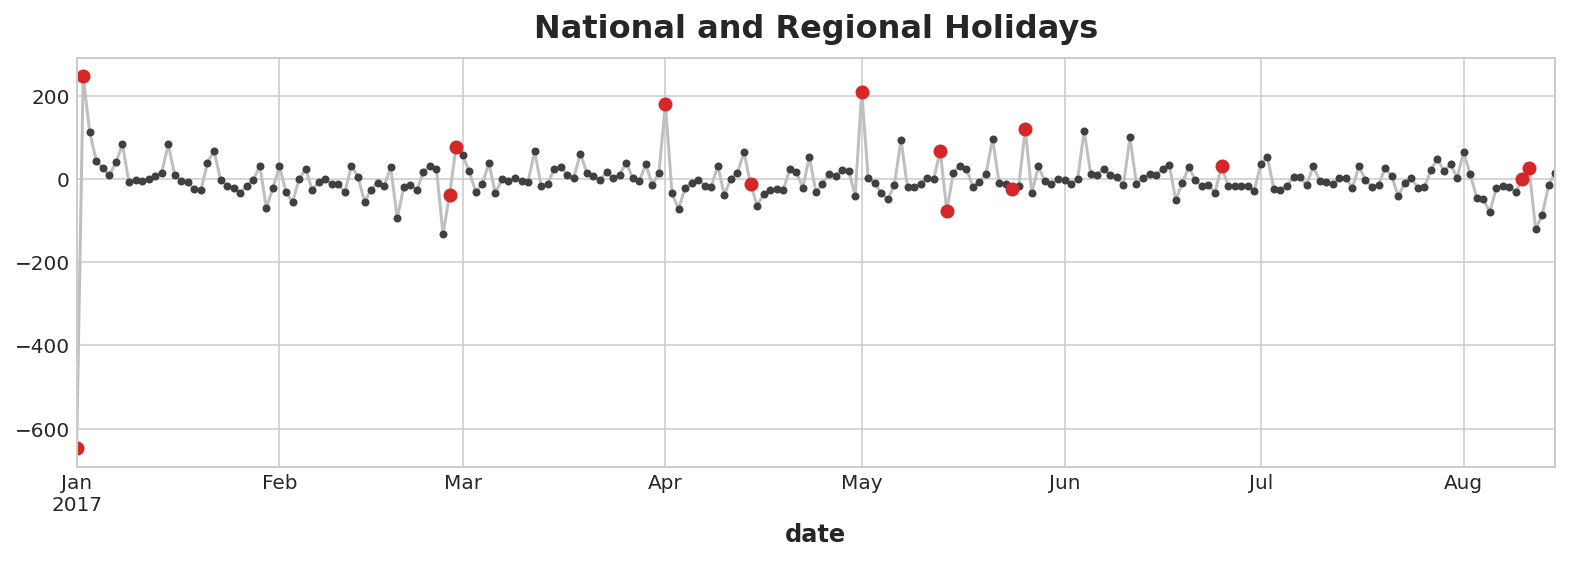

In [25]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

### 14) Create Holiday Features
What kind of features could you create to help your model make use of this information?

In [26]:
ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

In [27]:
# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

Now fit the seasonal model with holiday features added. Do the fitted values seem to have improved?

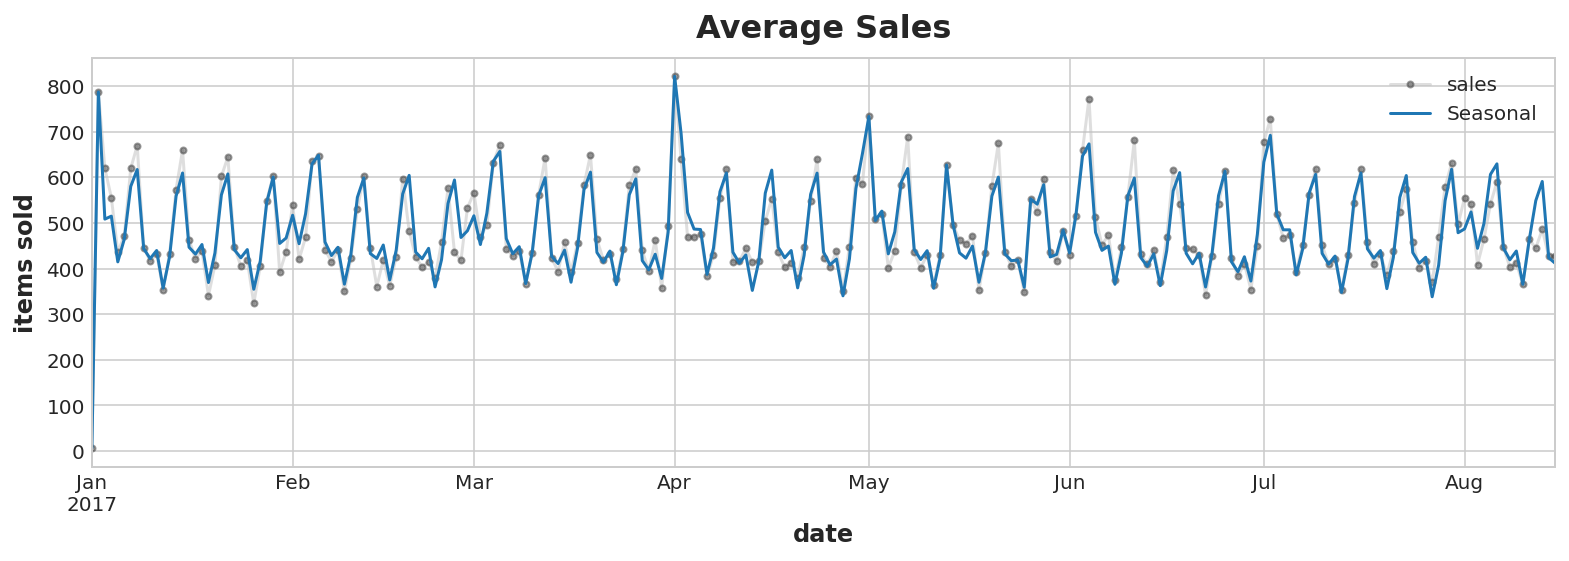

In [28]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

## First Submition to Store Sales competition

The next cell creates a seasonal model of the kind we've learned about for the full store sales dataset with all 1800 time series. 

In [29]:
y = store_sales_nuevo.unstack(['store_nbr', 'family']).loc['2017']

# Create Training Data
fourier = CalendarFourier(freq="M", order=4)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X,y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

You can use this cell to see some of its predictions.

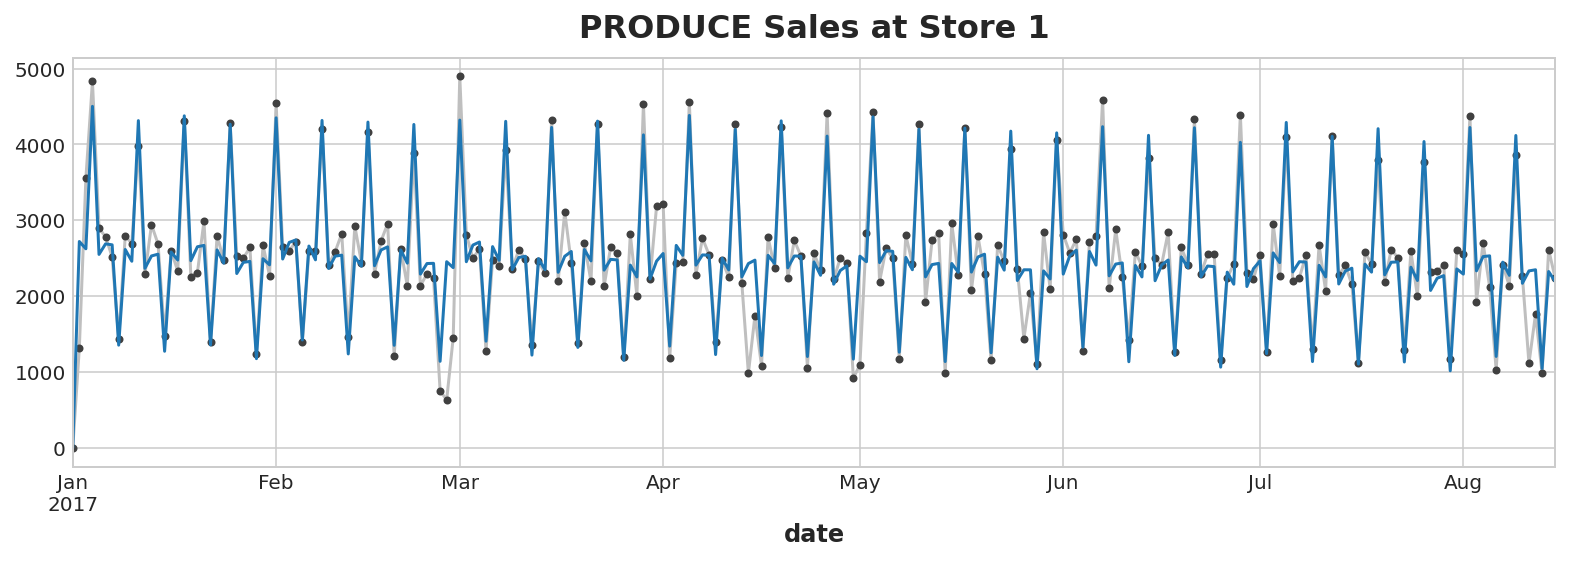

In [30]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

Finally, this cell loads the test data, creates a feature set for the forecast period, and then creates the submission file submission.csv.

In [31]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

----